Running on PyMC v5.23.0
Running on ArviZ v0.21.0


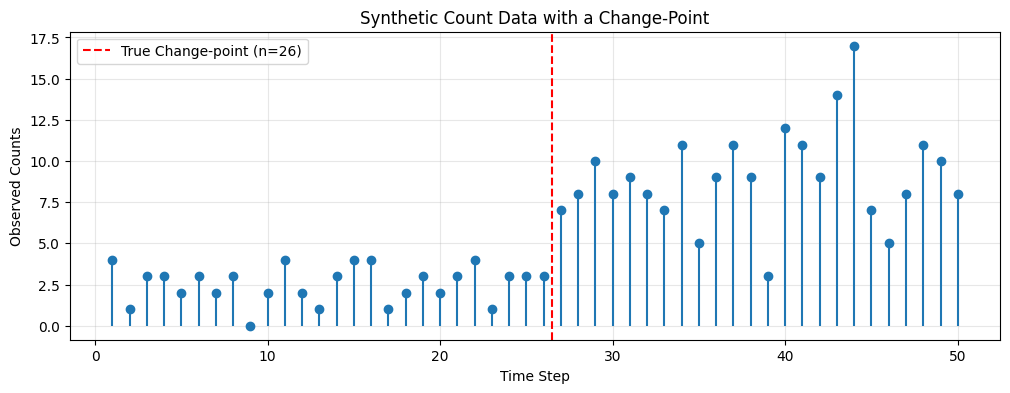


--- Running PyMC Implementation ---


Output()

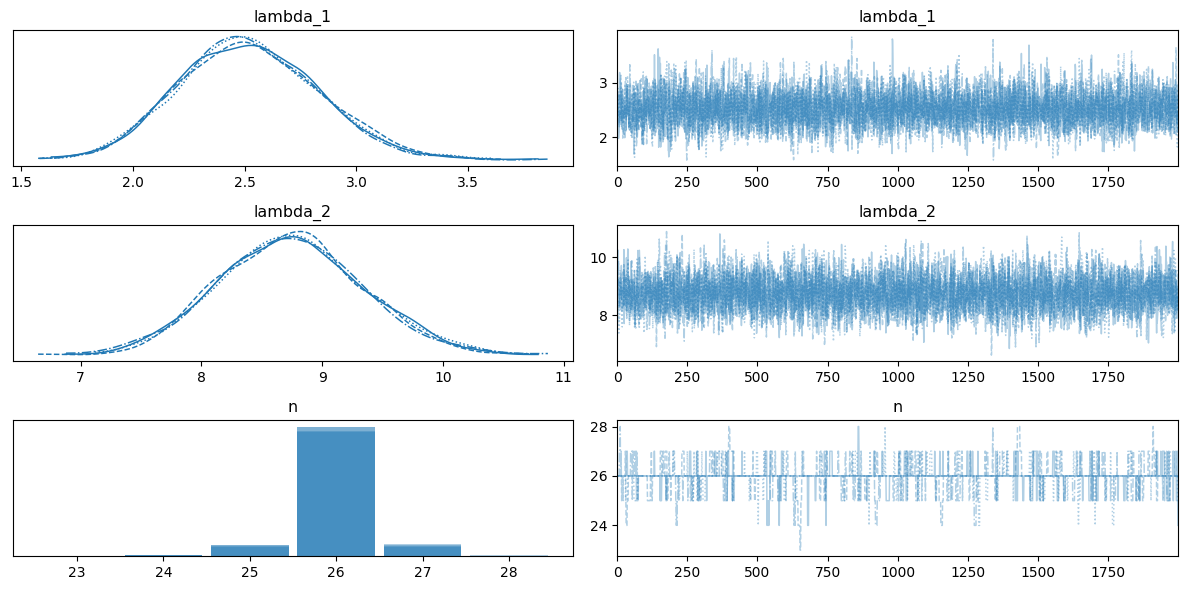


--- Running Manual Gibbs Sampler Implementation ---


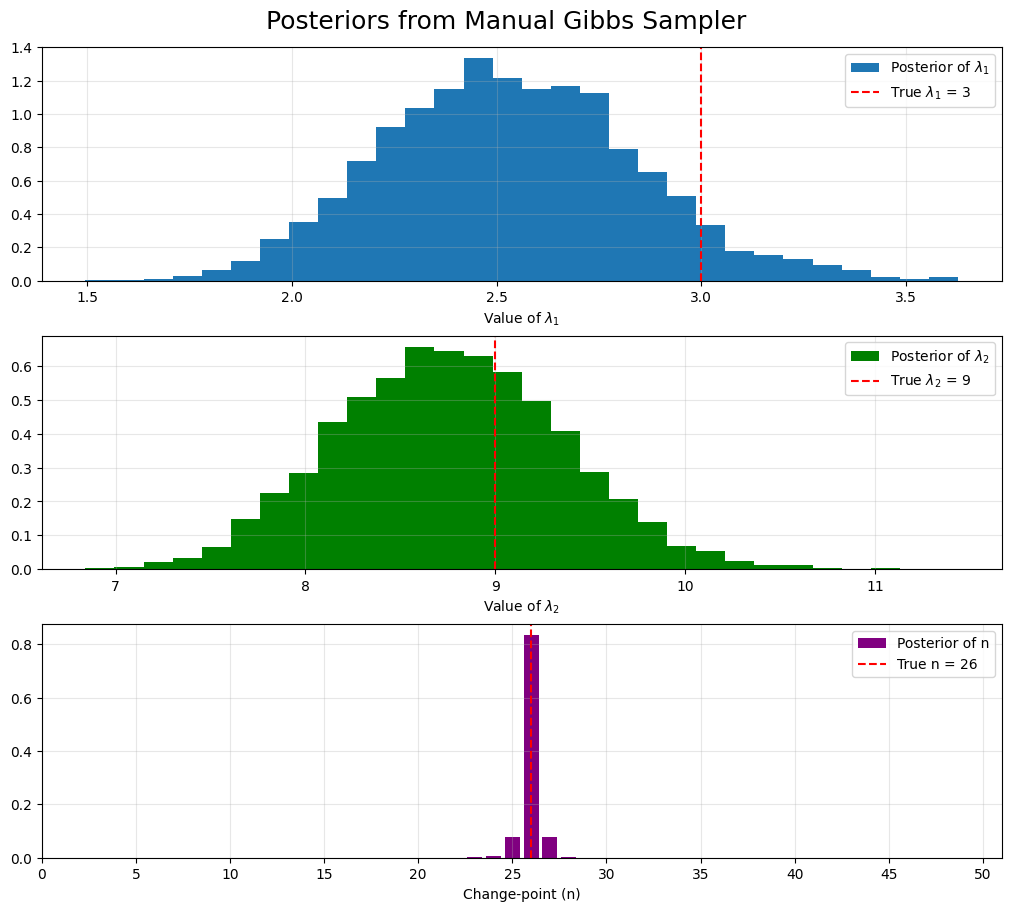

In [19]:
# Project 7: Pulling It All Together (Sheikh Islam, Wilson Jimenez, & Talha Akhlaq)

# Imports
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

# Display versions
print(f"Running on PyMC v{pm.__version__}")
print(f"Running on ArviZ v{az.__version__}")


# Define the true parameters for our synthetic data
N = 50          # Total number of time steps
n_true = 26     # The true change-point
lambda1_true = 3  # The true rate before the change-point
lambda2_true = 9  # The true rate after the change-point

# Generate the count data using a Poisson distribution
np.random.seed(42)  # For reproducibility
counts = np.zeros(N, dtype=np.int32)
# First part of the sequence with rate lambda1_true
counts[:n_true] = np.random.poisson(lambda1_true, size=n_true)
# Second part of the sequence with rate lambda2_true
counts[n_true:] = np.random.poisson(lambda2_true, size=N - n_true)

# Plot the generated data to see the change-point visually
fig, ax = plt.subplots(figsize=(12, 4))
ax.stem(np.arange(1, N + 1), counts, linefmt='C0-', markerfmt='C0o', basefmt=" ")
ax.axvline(n_true + 0.5, color='r', linestyle='--', label=f'True Change-point (n={n_true})')
ax.set_title('Synthetic Count Data with a Change-Point')
ax.set_xlabel('Time Step')
ax.set_ylabel('Observed Counts')
ax.legend()
ax.grid(alpha=0.3)
plt.show()


print("\n--- Running PyMC Implementation ---")

with pm.Model() as change_point_model:
    # Prior for the change-point 'n', as a discrete uniform variable
    n = pm.DiscreteUniform('n', lower=1, upper=N)

    # Priors for the rates lambda_1 and lambda_2, using Gamma distributions as specified in the paper (hyperparameters a=2, b=1)
    lambda_1 = pm.Gamma('lambda_1', alpha=2, beta=1)
    lambda_2 = pm.Gamma('lambda_2', alpha=2, beta=1)

    # The rate 'mu' at each time step is determined by the change-point 'n', will use pm.math.switch for conditional logic
    time_steps = np.arange(1, N + 1)
    mu = pm.math.switch(time_steps <= n, lambda_1, lambda_2)

    # The likelihood of the observed 'counts' is a Poisson distribution with the rate 'mu' determined above
    x_obs = pm.Poisson('x_obs', mu=mu, observed=counts)

    # Run the NUTS sampler to get posterior samples a high target_accept helps with models mixing discrete and continuous variables
    trace = pm.sample(2000, tune=1000, chains=4, cores=1, target_accept=0.95)

# Visualize the results: trace plots and posterior distributions
az.plot_trace(trace, var_names=['lambda_1', 'lambda_2', 'n'])
plt.tight_layout()
plt.show()


print("\n--- Running Manual Gibbs Sampler Implementation ---")

# Hyperparameters from the paper
a = 2
b = 1

# MCMC settings
n_iterations = 5200
burn_in = 200

# Initialize arrays to store the samples from each iteration
samples = {
    'lambda_1': np.zeros(n_iterations),
    'lambda_2': np.zeros(n_iterations),
    'n': np.zeros(n_iterations, dtype=np.int32)
}

# Set initial random values for the first step of the chain
samples['lambda_1'][0] = np.random.gamma(a, 1/b)
samples['lambda_2'][0] = np.random.gamma(a, 1/b)
samples['n'][0] = np.random.randint(1, N + 1)

# Pre-calculating cumulative sums avoids re-summing data in the loop
cumulative_counts = np.cumsum(counts)
total_sum = cumulative_counts[-1]

# Gibbs sampling loop
for i in range(1, n_iterations):
    # Get the state from the previous iteration
    prev_n = samples['n'][i-1]

    # Sample lambda_1 from its full conditional posterior
    sum_x_before_n = cumulative_counts[prev_n - 1]
    lambda_1_posterior_shape = a + sum_x_before_n
    lambda_1_posterior_rate = prev_n + b
    # Draw a new sample for lambda_1
    samples['lambda_1'][i] = np.random.gamma(lambda_1_posterior_shape, 1 / lambda_1_posterior_rate)

    # Sample lambda_2 from its full conditional posterior
    sum_x_after_n = total_sum - sum_x_before_n
    lambda_2_posterior_shape = a + sum_x_after_n
    lambda_2_posterior_rate = (N - prev_n) + b
    # Draw a new sample for lambda_2
    samples['lambda_2'][i] = np.random.gamma(lambda_2_posterior_shape, 1 / lambda_2_posterior_rate)

    # Use the newly sampled lambdas for updating n in this same iteration
    new_lambda_1 = samples['lambda_1'][i]
    new_lambda_2 = samples['lambda_2'][i]

    # Sample n from its full conditional posterior
    # Calculate the log probability for each possible change-point j = 1...N
    j_values = np.arange(1, N + 1)
    log_p_n = (cumulative_counts * np.log(new_lambda_1) - j_values * new_lambda_1 +
               (total_sum - cumulative_counts) * np.log(new_lambda_2) - (N - j_values) * new_lambda_2)

    # Convert log probabilities to probabilities and sample a new n
    p_n = np.exp(log_p_n - np.max(log_p_n))  # Subtract max for numerical stability
    p_n /= np.sum(p_n) # Normalize
    samples['n'][i] = np.random.choice(np.arange(1, N + 1), p=p_n)

# Discard the initial burn-in samples to ensure we have samples from the stationary distribution
final_samples = {key: val[burn_in:] for key, val in samples.items()}

# Create histograms of the final posterior samples
fig, axes = plt.subplots(3, 1, figsize=(10, 9), constrained_layout=True)
fig.suptitle("Posteriors from Manual Gibbs Sampler", fontsize=18)

# Plot posterior for lambda_1
axes[0].hist(final_samples['lambda_1'], bins=30, density=True, label=r'Posterior of $\lambda_1$')
axes[0].axvline(lambda1_true, color='r', linestyle='--', label=f'True $\lambda_1$ = {lambda1_true}')
axes[0].set_xlabel(r'Value of $\lambda_1$')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot posterior for lambda_2
axes[1].hist(final_samples['lambda_2'], bins=30, density=True, color='green', label=r'Posterior of $\lambda_2$')
axes[1].axvline(lambda2_true, color='r', linestyle='--', label=f'True $\lambda_2$ = {lambda2_true}')
axes[1].set_xlabel(r'Value of $\lambda_2$')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Plot posterior for n
axes[2].hist(final_samples['n'], bins=np.arange(1, N + 2) - 0.5, rwidth=0.8, density=True, color='purple', label='Posterior of n')
axes[2].axvline(n_true, color='r', linestyle='--', label=f'True n = {n_true}')
axes[2].set_xticks(range(0, N + 1, 5))
axes[2].set_xlabel('Change-point (n)')
axes[2].legend()
axes[2].set_xlim(0, N + 1)
axes[2].grid(alpha=0.3)

plt.show()

# Stretch Goal:

---

## Model:

**Observations**  
$$
x=(x_1,\dots,x_N),\qquad x_i\in\mathbb N
$$  

**Unknowns**  
$$
n\in\{1,\dots,N\},\qquad \lambda_1,\lambda_2>0
$$  

**Priors**  
$$
p(n)=\frac1N,\qquad
\lambda_1,\lambda_2\sim\operatorname{Gamma}(a,b)
$$  

**Likelihood**  
$$
p(x\mid n,\lambda_1,\lambda_2)=
\Bigl[\prod_{i=1}^{n}\operatorname{Pois}(x_i\mid\lambda_1)\Bigr]
\;\times\;
\Bigl[\prod_{i=n+1}^{N}\operatorname{Pois}(x_i\mid\lambda_2)\Bigr]
$$  

---

## Full-Conditional Derivations

### Rate before change-point (λ₁)

1. **Posterior kernel**  
   $$
   p(\lambda_1\mid n,x)\propto p(x_{1:n}\mid\lambda_1)\,p(\lambda_1)
   $$  

2. **Insert pdfs**  
   $$
   p(x_{1:n}\mid\lambda_1)=\prod_{i=1}^{n}\tfrac{e^{-\lambda_1}\lambda_1^{x_i}}{x_i!},
   \qquad
   p(\lambda_1)=\tfrac{b^{a}}{\Gamma(a)}\,\lambda_1^{a-1}e^{-b\lambda_1}
   $$  

3. **Collect λ₁ terms**  
   $$
   p(\lambda_1\mid n,x)\propto
   \lambda_1^{a-1+\sum_{i=1}^{n}x_i}\,
   e^{-(b+n)\lambda_1}
   $$  

4. **Identify Gamma kernel**  
   $$
   \boxed{\lambda_1\mid n,x\sim
          \operatorname{Gamma}\bigl(a+\sum_{i=1}^{n}x_i,\;b+n\bigr)}
   $$  

### Rate after change-point (λ₂)

$$
\boxed{\lambda_2\mid n,x\sim
       \operatorname{Gamma}\bigl(a+\sum_{i=n+1}^{N}x_i,\;b+N-n\bigr)}
$$  

### Change-point location n

$$
p(n=j\mid\lambda_1,\lambda_2,x)\propto
\exp\Bigl\{\sum_{i=1}^{j}(x_i\ln\lambda_1-\lambda_1)
         +\sum_{i=j+1}^{N}(x_i\ln\lambda_2-\lambda_2)\Bigr\},
\qquad j=1,\dots,N
$$  

(normalise the \(N\) weights to draw n from a categorical distribution)

---

## Pseudocode

```python
# Inputs -----------------------------------------------
# x[0..N-1]  : integer counts
# a, b       : Gamma hyper-parameters
# T          : total Gibbs iterations
# B          : burn-in iterations to discard
# Arrays     : 0-based; n is stored 1-based
# ------------------------------------------------------

N      = len(x)
cs     = cumsum(x)          # cumulative sums
total  = cs[N-1]

λ1 = draw_Gamma(a, b)
λ2 = draw_Gamma(a, b)
n  = UniformInt(1, N)        # 1 … N

for t in range(1, T + 1):

    # 1. λ₁ | n, x
    sum1 = cs[n-1]
    λ1   = draw_Gamma(a + sum1, b + n)

    # 2. λ₂ | n, x
    sum2 = total - sum1
    λ2   = draw_Gamma(a + sum2, b + (N - n))

    # 3. n | λ₁, λ₂, x
    j    = arange(1, N + 1)
    logw = cs*log(λ1) - j*λ1 + (total - cs)*log(λ₂) - (N - j)*λ₂
    w    = exp(logw - max(logw))      # shift for stability
    w   /= sum(w)
    n    = Categorical(w) + 1         # back to 1-index

    if t > B:
        store(λ₁, λ₂, n)


In [25]:
#-----------------------------------------------------------------------------#
# Gibbs sampler for the two–rate Poisson change-point model
#
# •  x           1-D NumPy array of non-negative integer counts (length N)
# •  a, b        hyper-parameters of the Gamma(a,b) prior on each rate λ
#                (shape = a,  rate = b).  Defaults a=2, b=1 as in the paper.
# •  T           total MCMC iterations
# •  B           burn-in iterations to discard  (0 < B < T)
# •  seed        optional random-seed for reproducibility
#
# The routine returns an array of size (T-B, 3) with columns
#   [ λ₁  λ₂  n ]  =  posterior draws of the two Poisson rates and
#                    the 1-based change-point location.
#
# A short synthetic-data demo runs when the file is executed directly:
#   * true N = 60, true change-point n = 35
#   * true rates λ₁ = 2.5  (before n),  λ₂ = 8.0  (after n)
#   After 8 000 iterations (2 000 burn-in) the script prints the
#   posterior means of λ₁, λ₂ and n so you can verify convergence.
#-----------------------------------------------------------------------------#

import numpy as np


def gibbs_poisson_change(x, a=2.0, b=1.0, T=10_000, B=2_000, seed=None):
    """Return posterior samples [λ1, λ2, n] from the Poisson change-point model."""
    if B >= T:
        raise ValueError("B (burn-in) must be smaller than T (total iterations).")

    rng   = np.random.default_rng(seed)
    x     = np.asarray(x, dtype=int)
    N     = x.size
    cs    = x.cumsum()              # cumulative sums for speed
    tot   = cs[-1]

    # random initial state
    lam1  = rng.gamma(a, 1 / b)
    lam2  = rng.gamma(a, 1 / b)
    n     = rng.integers(1, N + 1)  # 1 … N

    samples = np.empty((T - B, 3))
    k = 0

    for _ in range(T):
        # --- λ₁ | n, x
        sum1 = cs[n - 1]                 # Σ counts up to n
        lam1 = rng.gamma(a + sum1, 1 / (b + n))

        # --- λ₂ | n, x
        sum2 = tot - sum1
        lam2 = rng.gamma(a + sum2, 1 / (b + (N - n)))

        # --- n | λ₁, λ₂, x
        j     = np.arange(1, N + 1)
        logw  = (cs * np.log(lam1) - j * lam1) \
              + ((tot - cs) * np.log(lam2) - (N - j) * lam2)
        w     = np.exp(logw - logw.max())   # soft-max stabilisation
        w    /= w.sum()
        n     = rng.choice(j, p=w)          # 1…N (already 1-based)

        # store after burn-in
        if k < T - B:
            samples[k] = (lam1, lam2, n)
            k += 1

    return samples


# Generate synthetic data, run the sampler, print posterior means
if __name__ == "__main__":
    N          = 60
    n_true     = 35
    lam1_true  = 2.5
    lam2_true  = 8.0
    rng        = np.random.default_rng(0)

    # synthetic data
    x = np.concatenate([rng.poisson(lam1_true, n_true),
                        rng.poisson(lam2_true, N - n_true)])

    # run sampler
    draws = gibbs_poisson_change(x, T=8_000, B=2_000, seed=42)

    # summary
    m_lam1, m_lam2, m_n = draws.mean(axis=0)
    print("Posterior means:")
    print(f"  λ₁ ≈ {m_lam1:.3f}   (true {lam1_true})")
    print(f"  λ₂ ≈ {m_lam2:.3f}   (true {lam2_true})")
    print(f"   n ≈ {m_n:.1f}    (true {n_true})")


Posterior means:
  λ₁ ≈ 2.782   (true 2.5)
  λ₂ ≈ 8.404   (true 8.0)
   n ≈ 34.9    (true 35)
